# Phase 3: Trajectory Prediction on Real-World Data

# 🧭 Introduction

In this notebook, we will test our models on real-world data

The goal is still to predict the **future trajectory** of the self-driving car (SDC), but we now only have dashcam image and past trajectory a disposal ! 🎯

Let's see how well our model can generalize !


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# 📖 Libs

In [ ]:
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
import os
from collections import deque

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.amp import autocast, GradScaler

import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchvision.models import ResNet34_Weights

import pandas as pd
from IPython.display import clear_output
import gdown
import zipfile
import optuna
from tqdm import tqdm

# 📂 The Dataset

We are now working with a synthetic image dataset for training and a real-world image dataset for validation.

The data is stored in `.pkl` files and each file contains:
- `camera`: RGB image (shape: H x W x 3)
- `sdc_history_feature`: the past trajectory of the car
- `sdc_future_feature`: the future trajectory to predict

We'll define a `DrivingDataset` class to load and return these tensors in a format our model can work with.

In [ ]:
download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if"
output_zip = "dlav_val_real.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")


# 🔎 Data Visualisation

dict_keys(['camera', 'driving_command', 'sdc_history_feature', 'sdc_future_feature'])


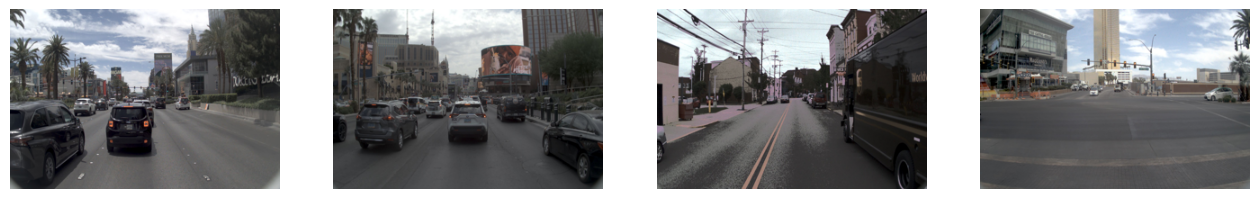

Camera shape: (200, 300, 3)
History shape: (21, 3)
Future shape: (60, 3)


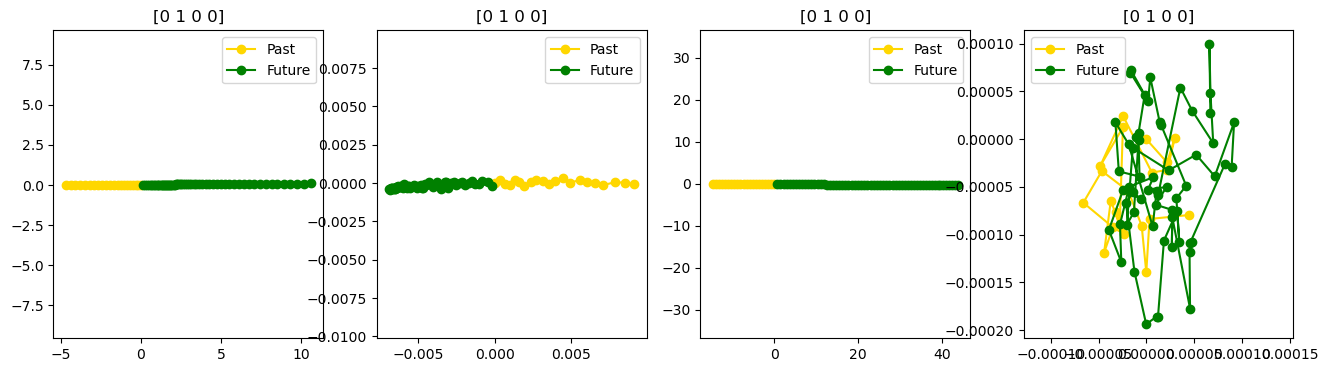

In [ ]:
k = 4
# load the data
data = []
for i in random.choices(np.arange(1000), k=k):
    with open(f"val_real/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))

print(data[0].keys())

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()


# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
    axis[i].set_title(data[i]["driving_command"])

print(f"Camera shape: {np.shape(data[0]['camera'])}")
print(f"History shape: {np.shape(data[0]['sdc_history_feature'])}")
print(f"Future shape: {np.shape(data[0]['sdc_future_feature'])}")
plt.show()

# 💾 Dataset class

Loads the data and does some basic preprocessing.

We can access camera and history data as well as depth, smantic and future states during training.

Some lighting augmentation is also applied to increase robustness.

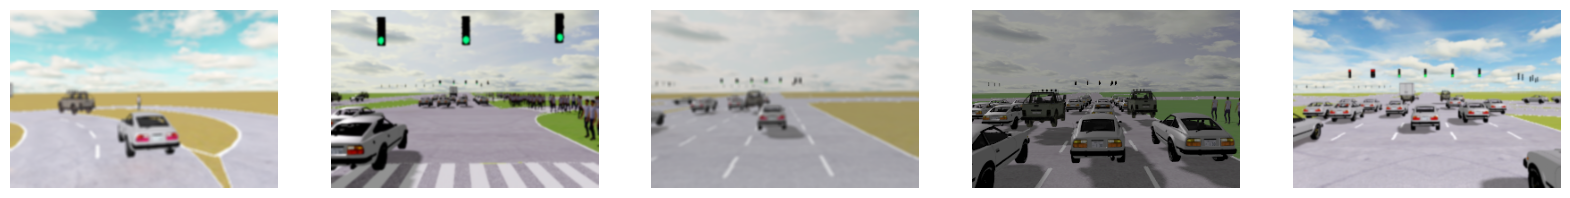

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

        self.transform = T.Compose([
                # T.Resize((224, 224), interpolation=T.InterpolationMode.BILINEAR),
                T.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.2, hue=0.1),
                T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
                # T.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                # T.RandomPerspective(distortion_scale=0.2, p=0.5),
                T.ToTensor(),
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        # camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0

        camera = Image.fromarray(data['camera'].astype(np.uint8))
        camera = self.transform(camera)  # (3, 224, 224)

        history = torch.FloatTensor(data['sdc_history_feature'])

        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {
                'camera': camera,
                'history': history,
                'future': future
            }
        else:
            return {
                'camera': camera,
                'history': history,
            }


# 5 random examples of augmentation
dataset = DrivingDataset(["train/2.pkl", "train/50.pkl", "train/305.pkl", "train/591.pkl", "train/904.pkl"])
fig, axis = plt.subplots(1, 5, figsize=(4*5, 4))
for i in range(5):
    data = dataset[i]
    axis[i].imshow(data["camera"].permute(1, 2, 0))
    axis[i].axis("off")
plt.show()

# 🗂️ Data Loader

In [ ]:
train_data_dir = "train"
val_data_dir = "val_real"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")

train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(val_files)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)

# I want to compute the mean and std of the training dataset for the images and depth
def compute_mean_std(loader):
    mean_img = 0.
    std_img = 0.
    mean_depth = 0.
    std_depth = 0.
    n_samples = 0
    for idx, batch in enumerate(tqdm(loader, desc=f"Epoch", leave=False)):
        camera = batch['camera']
        depth = batch['depth']
        n_samples += camera.size(0)

        mean_img += camera.mean([0, 2, 3])
        std_img += camera.std([0, 2, 3])

        mean_depth += depth.mean([0, 2, 3])
        std_depth += depth.std([0, 2, 3])
    mean_img /= n_samples
    std_img /= n_samples
    mean_depth /= n_samples
    std_depth /= n_samples
    return mean_img, std_img, mean_depth, std_depth

# mean_img, std_img, mean_depth, std_depth = compute_mean_std(train_loader)
# print(f"Mean image: {mean_img}")
# print(f"Std image: {std_img}")
# print(f"Mean depth: {mean_depth}")
# print(f"Std depth: {std_depth}")

Number of training samples: 5000
Number of validation samples: 1000


# 📈 Data Augmentation

Here a mixed training dataset composed of both synthetic and real-world images is augmented by flipping the originals

Augmented training data already exists. Skipping augmentation.
Number of augmented training samples: 5000
Loaded 859.pkl
Loaded flipped_859.pkl
Loaded 1547.pkl
Loaded flipped_1547.pkl
Loaded 50.pkl
Loaded flipped_50.pkl
Loaded 138.pkl
Loaded flipped_138.pkl


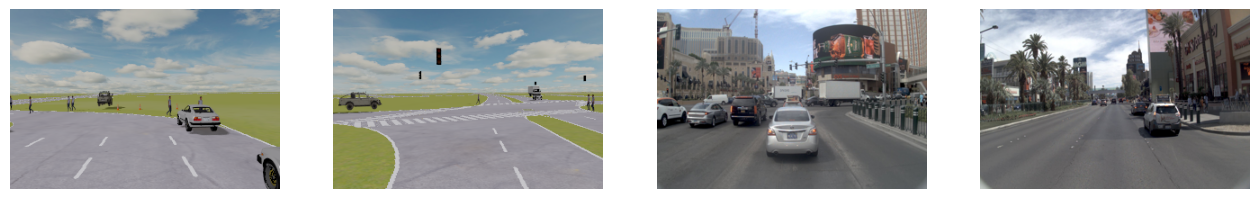

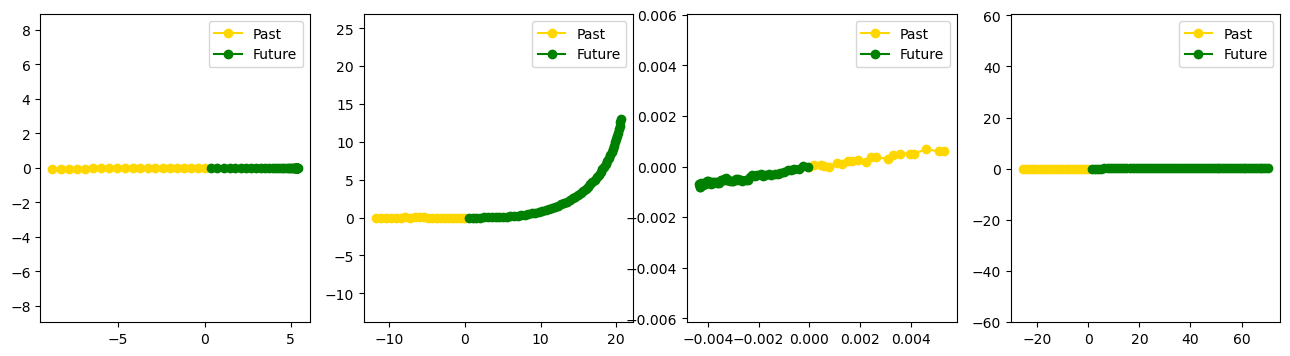

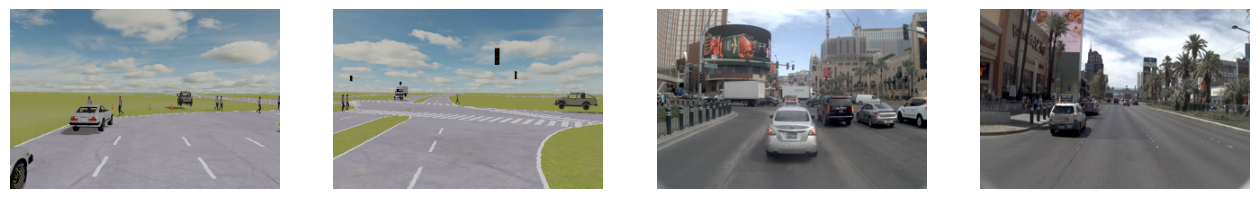

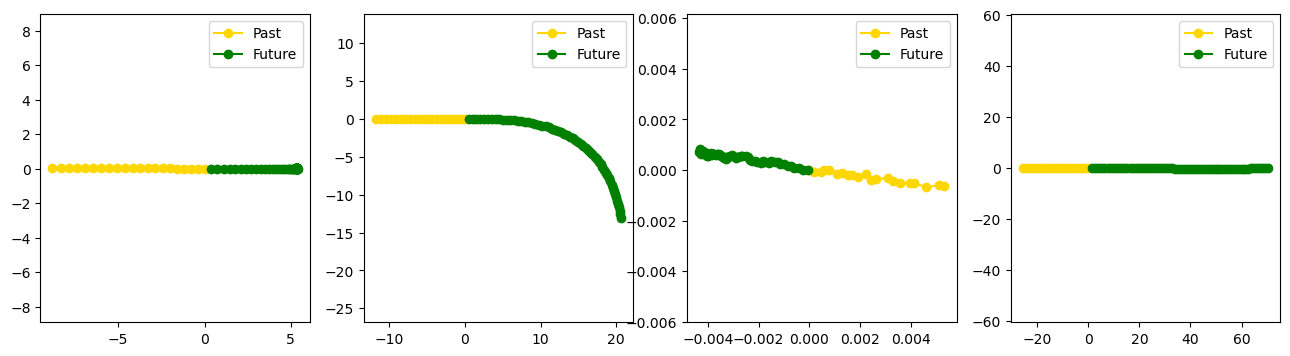

In [ ]:
def augment_and_save(file_list, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    new_files = []

    for file_path in tqdm(file_list):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        # Flip image horizontally
        camera = data['camera'][:, ::-1, :]  # shape HxWxC, flip width

        # Flip signs for 2nd and 3rd cols in history and future
        data['camera'] = camera
        data['sdc_history_feature'][:, 1:] *= -1

        if 'sdc_future_feature' in data:
            data['sdc_future_feature'][:, 1:] *= -1

        # Save to new file
        base = os.path.basename(file_path)
        new_path = os.path.join(save_dir, f"flipped_{base}")
        with open(new_path, 'wb') as f:
            pickle.dump(data, f)

        new_files.append(new_path)

    return new_files

train_files_mixed = train_files[500:] + val_files[:500]
test_files = val_files[500:]

train_dataset = DrivingDataset(train_files_mixed)
val_dataset = DrivingDataset(test_files)

if not os.path.exists('augmented_train'):
    augmented_train = augment_and_save(train_files_mixed, save_dir='augmented_train')
else:
    print("Augmented training data already exists. Skipping augmentation.")

augmented_train_files = [os.path.join("augmented_train", f) for f in os.listdir("augmented_train") if f.endswith('.pkl')]
# Create augmented datasets
augmented_train_dataset = DrivingDataset(augmented_train_files)

print(f"Number of augmented training samples: {len(augmented_train_files)}")

# load k data from augmented_samples
aug_data = []
data = []
k = 2
# load the data
for i in random.choices(np.arange(4500), k=k):
    i = i + 500
    with open(f".//train/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))
        print(f"Loaded {i}.pkl")
    with open(f".//augmented_train/flipped_{i}.pkl", "rb") as f:
        aug_data.append(pickle.load(f))
        print(f"Loaded flipped_{i}.pkl")

for i in random.choices(np.arange(500), k=k):
    with open(f".//val_real/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))
        print(f"Loaded {i}.pkl")
    with open(f".//augmented_train/flipped_{i}.pkl", "rb") as f:
        aug_data.append(pickle.load(f))
        print(f"Loaded flipped_{i}.pkl")

k = 4

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(aug_data[i]["camera"])
    axis[i].axis("off")
plt.show()

fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(aug_data[i]["sdc_history_feature"][:, 0], aug_data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(aug_data[i]["sdc_future_feature"][:, 0], aug_data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()



# 📈 Logger
Receives training metrics and logs and regularly plot them during training.


In [ ]:
class Logger:
    def __init__(self, base_dir="logs", run_prefix="run", save_every=100, plot_metrics=None, silent=True):
        self.base_dir = base_dir
        self.run_prefix = run_prefix
        self.save_every = save_every
        self.plot_metrics = plot_metrics
        self.silent = silent
        self.last_saved_step = -1
        self.history = {}
        self.latest_logs = deque(maxlen=10)
        self.figures = {}

        os.makedirs(self.base_dir, exist_ok=True)
        self.log_dir = self._create_unique_run_dir()
        os.makedirs(self.log_dir, exist_ok=True)

        if not self.silent:
            print(f"Logging to {self.log_dir}")

    def _create_unique_run_dir(self):
        i = 0
        while os.path.exists(os.path.join(self.base_dir, f"{self.run_prefix}_{i}")):
            i += 1
        return os.path.join(self.base_dir, f"{self.run_prefix}_{i}")

    def log(self, step=None, **metrics):
        prefix = f"[Step {step}] " if step is not None else ""
        metric_str = " | ".join(f"{k}: {v:.4f}" for k, v in metrics.items())
        log_entry = prefix + metric_str
        self.latest_logs.append(log_entry)

        if not self.silent:
            clear_output(wait=True)  # Clear notebook output
            for entry in self.latest_logs:
                print(entry)

        for key, value in metrics.items():
            if key not in self.history:
                self.history[key] = []
            self.history[key].append((step, value))

        if step is not None and (step - self.last_saved_step) >= self.save_every:
            self.plot(step)
            self.last_saved_step = step

    def plot(self, step=None):
        if not self.history:
            if not self.silent:
                print("No metrics to plot yet.")
            return

        for key, values in self.history.items():
            if self.plot_metrics is None or key in self.plot_metrics:
                steps, vals = zip(*values)

                if key not in self.figures:
                    fig, ax = plt.subplots(figsize=(8, 5))
                    self.figures[key] = (fig, ax)
                else:
                    fig, ax = self.figures[key]

                ax.clear()
                ax.plot(steps, vals, label=key, color='tab:blue')
                ax.set_xlabel("Step")
                ax.set_ylabel(key)
                ax.set_title(f"{key} over Steps")
                ax.grid(True)
                ax.legend()

                fig.tight_layout()

                plot_path = os.path.join(self.log_dir, f"{key}_plot.png")
                fig.savefig(plot_path)
                fig.canvas.draw()
                fig.canvas.flush_events()


## 🧠 The Model: Trajectory + Depth Prediction

We've extended our trajectory prediction model to optionally include a **depth estimation decoder** and a **semantics decoder**.

This model is composed of:
- A pretrained RNN backbone to extract features from the image
- An MLP to process historical trajectory features
- A depth and semantics decoders (MLP) to predict dense depth maps
- A Fusion Layer to aggregates Visual features and motion history
- A trajectory decoder to predict future coordinates

In [ ]:
class BetterDrivingPlanner(nn.Module):
    def __init__(self,
                 num_modes=6,
                 future_steps=60,
                 dropout_val=0,
                 use_layernorm=False,
                 freeze_pretrained=False
                ):

        super().__init__()

        self.num_modes = num_modes
        self.future_steps = future_steps
        self.dropout_val = dropout_val
        self.use_layernorm = use_layernorm

        # Visual encoder: ResNet34 pretrained
        resnet = models.resnet34(pretrained=True)
        self.visual_encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.visual_pool = nn.AdaptiveAvgPool2d((1, 1))  # Pool to (batch, channels, 1, 1)
        self.visual_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_val)
        )

        if freeze_pretrained:
            for param in self.visual_encoder.parameters():
                param.requires_grad = False
            # Unfreeze the last block (layer4) and the final convolutional layer
            for name, param in self.visual_encoder.named_parameters():
                if "layer4" in name or "conv1" in name:
                    param.requires_grad = True

        # History encoder
        self.history_encoder = nn.Sequential(
            nn.Linear(21 * 3, 256),
            nn.ReLU(),
            nn.Dropout(dropout_val),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.LayerNorm(128) if use_layernorm else nn.Identity(),
            nn.Dropout(dropout_val)
        )

        # Fusion MLP with optional Dropout for stabilization
        fusion_input_size = 256 + 128

        self.fusion = nn.Sequential(
            nn.Linear(fusion_input_size, 512),
            nn.ReLU(),
            nn.LayerNorm(512) if use_layernorm else nn.Identity(),
            nn.Dropout(dropout_val),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.LayerNorm(512) if use_layernorm else nn.Identity(),
            nn.Dropout(dropout_val)
        )

        # Trajectory decoder
        # Predict K trajectories + confidence scores
        self.trajectory_head = nn.Linear(512, self.num_modes * self.future_steps * 3)  # (x, y) only, no heading
        self.confidence_head = nn.Linear(512, self.num_modes)  # One confidence score per mode


    def forward(self, camera, history):
        batch_size = camera.size(0)

        # Encode camera image
        visual_encoded = self.visual_encoder(camera)  # (B, 512, H', W')
        visual_features = self.visual_pool(visual_encoded).view(batch_size, -1)  # (B, 512)
        visual_features = self.visual_fc(visual_features)  # (B, 256)

        # Encode history
        history_flat = history.reshape(batch_size, -1)
        history_features = self.history_encoder(history_flat)  # (B, 128)

        # Optional auxiliary outputs & embeddings
        fusion_inputs = [visual_features, history_features]

        # Fuse features
        fused = torch.cat(fusion_inputs, dim=-1)
        fused = self.fusion(fused)  # (B, 512)

        # Predict trajectory
        traj = self.trajectory_head(fused)  # (B, num_modes * future_steps * 2)
        traj = traj.view(batch_size, self.num_modes, self.future_steps, 3)

        conf = self.confidence_head(fused)  # (B, num_modes)
        conf = nn.functional.gumbel_softmax(self.confidence_head(fused), tau=1, hard=True)


        return traj, conf

    def predict_best(self, traj, conf):
        """
        Given predicted trajectories and confidence scores,
        select the most probable trajectory.
        """
        best_idx = conf.argmax(dim=1)  # (B,)
        batch_size = traj.size(0)
        best_traj = traj[torch.arange(batch_size), best_idx]  # (B, future_steps, 2)
        return best_traj



## 🚀 Trainer with Auxiliary Loss

The training loop is similar to Phase 1 — except now, if enabled, we also compute a loss on the predicted **depth map**.

We define:
- `trajectory_loss` as weighted MSE between predicted and true future trajectory
- `depth_loss` as smooth L1 loss between predicted and ground truth depth
- 'semantic_loss' as CrossEntropy Loss to select the most probable semantic !  

Total loss = `trajectory_loss + lambda_depth * depth_loss + lambda_semantic * semantic_loss`

This helps guide the model to learn better representations from visual input. The weight `lambda` is a hyperparameter you can tune!

In [ ]:
def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler=None,
    logger=None,
    num_epochs=50
):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterions = {
        'traj': nn.SmoothL1Loss(reduction='none'),  # MSE loss for trajectory
        'depth': nn.SmoothL1Loss(reduction='none'),  # L1 loss for depth
        'semantic': nn.CrossEntropyLoss(reduction='none')  # Cross-entropy for semantic segmentation
    }

    scaler = GradScaler()  # for mixed precision

    # Define augmentation and normalization transforms
    augmentations = T.Compose([
            T.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.2, hue=0.1),
            # T.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            # T.RandomPerspective(distortion_scale=0.2, p=0.5),
            T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    ])

    # normalize = T.Compose([
    #     T.ConvertImageDtype(torch.float),  # ensure float tensor
    #     T.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
    #                 std=[0.229, 0.224, 0.225])   # ImageNet stds
    # ])

    best_val_ade = [np.inf, np.inf, np.inf]
    best_val_fde = [np.inf, np.inf, np.inf]

    # Normalization factors for loss scaling
    traj_norm = 1
    depth_norm = 1
    semantic_norm = 1

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)):
            camera = batch['camera'].to(device)    # (B, 3, H, W)
            history = batch['history'].to(device)  # (B, T, 3)
            future = batch['future'].to(device)    # (B, T, 3)

            optimizer.zero_grad()

            # Apply augmentations only during training
            camera = torch.stack([augmentations(img) for img in camera])

            # Always normalize
            # camera = normalize(camera)

            with autocast('cuda'):  # mixed precision
                traj_pred, conf_pred = model(camera, history)  # (B, num_modes, T, 2), (B, num_modes), ...

                # Expand ground truth to match modes
                future_expand = future[:, None, :, :].expand_as(traj_pred)

                # Compute loss for each mode
                loss_per_mode = criterions['traj'](traj_pred, future_expand).mean(dim=[2,3])  # (B, num_modes)
                weighted_traj_loss = (loss_per_mode * conf_pred).sum(dim=1).mean()

                # Combine all losses
                total_loss = weighted_traj_loss 

                scaler.scale(total_loss).backward()

            # Gradient clipping (optional but safer)
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            scaler.step(optimizer)
            scaler.update()

            # Logging
            if idx % 10 == 0 and logger is not None:
                log_data = {
                    'total_loss': total_loss.item()/len(train_loader),
                    'weighted_traj_loss': weighted_traj_loss.item()/len(train_loader)
                }

                logger.log(step=epoch * len(train_loader) + idx, **log_data)


            train_loss += total_loss.item()

        # Validation
        model.eval()
        val_loss, ade_all, fde_all = 0, [], []
        with torch.no_grad():
            for batch in val_loader:
                camera = batch['camera'].to(device)
                history = batch['history'].to(device)
                future = batch['future'].to(device)

                # Only normalize (no augmentations during validation)
                # camera = normalize(camera)

                traj_pred, conf_pred = model(camera, history)
                best_traj = model.predict_best(traj_pred, conf_pred)

                ADE = torch.norm(best_traj[..., :2] - future[..., :2], dim=-1).mean()
                FDE = torch.norm(best_traj[:, -1, :2] - future[:, -1, :2], dim=-1).mean()
                loss = criterions['traj'](best_traj[..., :2], future[..., :2]).mean()

                ade_all.append(ADE.item())
                fde_all.append(FDE.item())
                val_loss += loss.item()

        current_ade = np.mean(ade_all)

        if scheduler is not None:
            scheduler.step()

        # save the best models
        dir = 'models'
        os.makedirs(dir, exist_ok=True)
        if current_ade < best_val_ade[0]:
            best_val_ade = [current_ade, best_val_ade[0], best_val_ade[1]]
            best_val_fde = [np.mean(fde_all), best_val_fde[0], best_val_fde[1]]
            print(f"New best val ADE: {best_val_ade}, FDE: {best_val_fde}")

            # Save the model
            if os.path.exists(os.path.join(dir, "third.pth")):
                os.remove(os.path.join(dir, "third.pth"))
            if os.path.exists(os.path.join(dir, "second.pth")):
                os.rename(os.path.join(dir, "second.pth"), os.path.join(dir, "third.pth"))
            if os.path.exists(os.path.join(dir, "best.pth")):
                os.rename(os.path.join(dir, "best.pth"), os.path.join(dir, "second.pth"))

            torch.save(model.state_dict(), os.path.join(dir, "best.pth"))

        elif current_ade < best_val_ade[1]:
            best_val_ade = [best_val_ade[0], current_ade, best_val_ade[1]]
            best_val_fde = [best_val_fde[0], np.mean(fde_all), best_val_fde[1]]
            # Save the model
            if os.path.exists(os.path.join(dir, "third.pth")):
                os.remove(os.path.join(dir, "third.pth"))
            if os.path.exists(os.path.join(dir, "second.pth")):
                os.rename(os.path.join(dir, "second.pth"), os.path.join(dir, "third.pth"))

            torch.save(model.state_dict(), os.path.join(dir, "second.pth"))

        elif current_ade < best_val_ade[2]:
            best_val_ade = [best_val_ade[0], best_val_ade[1], current_ade]
            best_val_fde = [best_val_fde[0], best_val_fde[1], np.mean(fde_all)]
            # Save the model
            if os.path.exists(os.path.join(dir, "third.pth")):
                os.remove(os.path.join(dir, "third.pth"))
            torch.save(model.state_dict(), os.path.join(dir, "third.pth"))

        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Loss: {val_loss/len(val_loader):.4f} | "
              f"ADE: {np.mean(ade_all):.4f} | FDE: {np.mean(fde_all):.4f}")

    return best_val_ade, best_val_fde


# 🗂️ Training Loader

In [ ]:
train_data_dir = "train"
real_data_dir = "val_real"
aug_data_dir = "augmented_train"
train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
test_files = [os.path.join(real_data_dir, f) for f in os.listdir(real_data_dir) if f.endswith('.pkl')]
augmented_train_files = [os.path.join(aug_data_dir, f) for f in os.listdir(aug_data_dir) if f.endswith('.pkl')]


# train_dataset = DrivingDataset(train_files + augmented_train_files + test_files[:500])
train_dataset = DrivingDataset(augmented_train_files[:500] + test_files[:500])
val_dataset = DrivingDataset(test_files[500:])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

## 🧪 Hyperparam Tuning

In [ ]:
def build_model_from_trial(trial):
    # Suggested hyperparameters
    # dropout_val = trial.suggest_float("dropout", 0.0, 0.3)
    # use_layernorm = trial.suggest_categorical("use_layernorm", [True, False])

    num_modes= trial.suggest_int("modes", 2, 6)
    future_steps=60
    freeze = trial.suggest_categorical("freeze", [True, False])

    # You could pass these as args or set them globally
    model = BetterDrivingPlanner(
        num_modes=num_modes,
        future_steps=future_steps,
        dropout_val=0.05,
        use_layernorm=True,
        use_depth_aux=True,
        use_semantic_aux=False,
        freeze_pretrained=freeze
    )
    return model

def objective(trial):
    # Search space
    # weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    # lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    # scheduler_time = trial.suggest_int("scheduler_time", 1, 5)
    # scheduler_gamma = trial.suggest_float("scheduler_gamma", 0.1, 1)
    l_depth = trial.suggest_float("l_depth", 0, 0.5)
    # l_semantic = trial.suggest_float("l_semantic", 0, 0.5)

    model = build_model_from_trial(trial)

    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr= 4.7e-04,
                                  weight_decay=3.5e-06
                                 )

    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_time, gamma=scheduler_gamma)  # halve lr every 20 epochs
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # halve lr every 20 epochs


    best_val_ade = train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        logger=None,  # optionally disable during tuning
        num_epochs=5,  # fewer epochs during tuning
        lambda_depth= l_depth,
        lambda_semantic= 0.2 # l_semantic
    )



    return best_val_ade[0]

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-05-16 18:25:45,819] A new study created in memory with name: no-name-2cabd7d1-a191-42e4-8be7-806c39cca726


New best val ADE: [np.float64(3.8318901136517525), inf, inf], FDE: [np.float64(9.36826778948307), inf, inf]
[Epoch 1/5] Train Loss: 92.6752 | Val Loss: 1.8635 | ADE: 3.8319 | FDE: 9.3683


New best val ADE: [np.float64(2.7337755113840103), np.float64(3.8318901136517525), inf], FDE: [np.float64(7.300983935594559), np.float64(9.36826778948307), inf]
[Epoch 2/5] Train Loss: 53.1877 | Val Loss: 1.2860 | ADE: 2.7338 | FDE: 7.3010


[Epoch 3/5] Train Loss: 12.3379 | Val Loss: 1.5893 | ADE: 3.3422 | FDE: 7.9903


New best val ADE: [np.float64(2.6813934594392776), np.float64(2.7337755113840103), np.float64(3.3421843722462654)], FDE: [np.float64(6.858230218291283), np.float64(7.300983935594559), np.float64(7.990330547094345)]
[Epoch 4/5] Train Loss: 3.2046 | Val Loss: 1.2464 | ADE: 2.6814 | FDE: 6.8582


[I 2025-05-16 18:33:21,454] Trial 0 finished with value: 2.5807977989315987 and parameters: {'l_depth': 0.4538036338725939, 'modes': 3, 'freeze': False}. Best is trial 0 with value: 2.5807977989315987.


New best val ADE: [np.float64(2.5807977989315987), np.float64(2.6813934594392776), np.float64(2.7337755113840103)], FDE: [np.float64(6.74649752676487), np.float64(6.858230218291283), np.float64(7.300983935594559)]
[Epoch 5/5] Train Loss: 1.5274 | Val Loss: 1.2064 | ADE: 2.5808 | FDE: 6.7465


New best val ADE: [np.float64(3.618811070919037), inf, inf], FDE: [np.float64(9.194227173924446), inf, inf]
[Epoch 1/5] Train Loss: 40.7340 | Val Loss: 1.7294 | ADE: 3.6188 | FDE: 9.1942


New best val ADE: [np.float64(2.5220603309571743), np.float64(3.618811070919037), inf], FDE: [np.float64(6.824489340186119), np.float64(9.194227173924446), inf]
[Epoch 2/5] Train Loss: 23.3973 | Val Loss: 1.1787 | ADE: 2.5221 | FDE: 6.8245


[Epoch 3/5] Train Loss: 7.1638 | Val Loss: 1.3451 | ADE: 2.8507 | FDE: 7.1239


New best val ADE: [np.float64(2.467791832983494), np.float64(2.5220603309571743), np.float64(2.8507088869810104)], FDE: [np.float64(6.431655824184418), np.float64(6.824489340186119), np.float64(7.123905062675476)]
[Epoch 4/5] Train Loss: 2.2837 | Val Loss: 1.1651 | ADE: 2.4678 | FDE: 6.4317


[I 2025-05-16 18:40:54,659] Trial 1 finished with value: 2.467791832983494 and parameters: {'l_depth': 0.19530368430911782, 'modes': 4, 'freeze': False}. Best is trial 1 with value: 2.467791832983494.


[Epoch 5/5] Train Loss: 1.2744 | Val Loss: 1.6608 | ADE: 3.4706 | FDE: 8.3014


New best val ADE: [np.float64(3.3621418103575706), inf, inf], FDE: [np.float64(9.33980417251587), inf, inf]
[Epoch 1/5] Train Loss: 25.2903 | Val Loss: 1.6110 | ADE: 3.3621 | FDE: 9.3398


New best val ADE: [np.float64(3.2228588238358498), np.float64(3.3621418103575706), inf], FDE: [np.float64(8.065101131796837), np.float64(9.33980417251587), inf]
[Epoch 2/5] Train Loss: 14.8393 | Val Loss: 1.5324 | ADE: 3.2229 | FDE: 8.0651


New best val ADE: [np.float64(3.0759137496352196), np.float64(3.2228588238358498), np.float64(3.3621418103575706)], FDE: [np.float64(7.653726816177368), np.float64(8.065101131796837), np.float64(9.33980417251587)]
[Epoch 3/5] Train Loss: 4.4077 | Val Loss: 1.4653 | ADE: 3.0759 | FDE: 7.6537


New best val ADE: [np.float64(2.51642619818449), np.float64(3.0759137496352196), np.float64(3.2228588238358498)], FDE: [np.float64(6.422273501753807), np.float64(7.653726816177368), np.float64(8.065101131796837)]
[Epoch 4/5] Train Loss: 1.8155 | Val Loss: 1.1836 | ADE: 2.5164 | FDE: 6.4223


[I 2025-05-16 18:48:23,433] Trial 2 finished with value: 2.51642619818449 and parameters: {'l_depth': 0.11830194400805144, 'modes': 3, 'freeze': True}. Best is trial 1 with value: 2.467791832983494.


[Epoch 5/5] Train Loss: 1.2738 | Val Loss: 1.6038 | ADE: 3.4014 | FDE: 7.7749


New best val ADE: [np.float64(3.4654944762587547), inf, inf], FDE: [np.float64(8.799210399389267), inf, inf]
[Epoch 1/5] Train Loss: 22.7681 | Val Loss: 1.6693 | ADE: 3.4655 | FDE: 8.7992


New best val ADE: [np.float64(2.8278841748833656), np.float64(3.4654944762587547), inf], FDE: [np.float64(7.2393118143081665), np.float64(8.799210399389267), inf]
[Epoch 2/5] Train Loss: 13.2396 | Val Loss: 1.3276 | ADE: 2.8279 | FDE: 7.2393


New best val ADE: [np.float64(2.446811955422163), np.float64(2.8278841748833656), np.float64(3.4654944762587547)], FDE: [np.float64(6.437028914690018), np.float64(7.2393118143081665), np.float64(8.799210399389267)]
[Epoch 3/5] Train Loss: 4.5638 | Val Loss: 1.1280 | ADE: 2.4468 | FDE: 6.4370


[Epoch 4/5] Train Loss: 1.7003 | Val Loss: 1.2126 | ADE: 2.6096 | FDE: 6.9547


[I 2025-05-16 18:56:38,153] Trial 3 finished with value: 2.396898042410612 and parameters: {'l_depth': 0.10514292728926278, 'modes': 3, 'freeze': False}. Best is trial 3 with value: 2.396898042410612.


New best val ADE: [np.float64(2.396898042410612), np.float64(2.446811955422163), np.float64(2.6095614060759544)], FDE: [np.float64(6.322104945778847), np.float64(6.437028914690018), np.float64(6.954712465405464)]
[Epoch 5/5] Train Loss: 1.1532 | Val Loss: 1.0973 | ADE: 2.3969 | FDE: 6.3221


New best val ADE: [np.float64(3.412164628505707), inf, inf], FDE: [np.float64(9.430590718984604), inf, inf]
[Epoch 1/5] Train Loss: 76.0972 | Val Loss: 1.6363 | ADE: 3.4122 | FDE: 9.4306


New best val ADE: [np.float64(2.490404698997736), np.float64(3.412164628505707), inf], FDE: [np.float64(6.864747986197472), np.float64(9.430590718984604), inf]
[Epoch 2/5] Train Loss: 40.8213 | Val Loss: 1.1744 | ADE: 2.4904 | FDE: 6.8647


[Epoch 3/5] Train Loss: 9.2555 | Val Loss: 1.3118 | ADE: 2.7667 | FDE: 7.0596


New best val ADE: [np.float64(2.3494683131575584), np.float64(2.490404698997736), np.float64(2.766719728708267)], FDE: [np.float64(6.193012095987797), np.float64(6.864747986197472), np.float64(7.0595545917749405)]
[Epoch 4/5] Train Loss: 3.4491 | Val Loss: 1.0917 | ADE: 2.3495 | FDE: 6.1930


[I 2025-05-16 19:03:59,790] Trial 4 finished with value: 2.3043381050229073 and parameters: {'l_depth': 0.37094644780860464, 'modes': 5, 'freeze': True}. Best is trial 4 with value: 2.3043381050229073.


New best val ADE: [np.float64(2.3043381050229073), np.float64(2.3494683131575584), np.float64(2.490404698997736)], FDE: [np.float64(6.0607058852910995), np.float64(6.193012095987797), np.float64(6.864747986197472)]
[Epoch 5/5] Train Loss: 1.9128 | Val Loss: 1.0587 | ADE: 2.3043 | FDE: 6.0607


New best val ADE: [np.float64(3.726768709719181), inf, inf], FDE: [np.float64(10.068002760410309), inf, inf]
[Epoch 1/5] Train Loss: 2.8830 | Val Loss: 1.7953 | ADE: 3.7268 | FDE: 10.0680


New best val ADE: [np.float64(2.5924425795674324), np.float64(3.726768709719181), inf], FDE: [np.float64(7.027728259563446), np.float64(10.068002760410309), inf]
[Epoch 2/5] Train Loss: 1.4997 | Val Loss: 1.2122 | ADE: 2.5924 | FDE: 7.0277


[Epoch 3/5] Train Loss: 1.0398 | Val Loss: 1.3985 | ADE: 2.9419 | FDE: 7.3672


[Epoch 4/5] Train Loss: 0.8952 | Val Loss: 1.2463 | ADE: 2.6807 | FDE: 6.7303


[I 2025-05-16 19:11:31,412] Trial 5 finished with value: 2.5924425795674324 and parameters: {'l_depth': 0.003896210884926088, 'modes': 6, 'freeze': False}. Best is trial 4 with value: 2.3043381050229073.


[Epoch 5/5] Train Loss: 0.8159 | Val Loss: 1.2896 | ADE: 2.7511 | FDE: 6.9219


New best val ADE: [np.float64(3.2380860820412636), inf, inf], FDE: [np.float64(9.153719514608383), inf, inf]
[Epoch 1/5] Train Loss: 23.9256 | Val Loss: 1.5423 | ADE: 3.2381 | FDE: 9.1537


New best val ADE: [np.float64(3.0400474295020103), np.float64(3.2380860820412636), inf], FDE: [np.float64(7.8166477382183075), np.float64(9.153719514608383), inf]
[Epoch 2/5] Train Loss: 13.4576 | Val Loss: 1.4488 | ADE: 3.0400 | FDE: 7.8166


[Epoch 3/5] Train Loss: 4.0049 | Val Loss: 2.2403 | ADE: 4.6102 | FDE: 10.5522


New best val ADE: [np.float64(2.78223118185997), np.float64(3.0400474295020103), np.float64(3.2380860820412636)], FDE: [np.float64(6.882923513650894), np.float64(7.8166477382183075), np.float64(9.153719514608383)]
[Epoch 4/5] Train Loss: 1.7713 | Val Loss: 1.3059 | ADE: 2.7822 | FDE: 6.8829


[I 2025-05-16 19:19:02,646] Trial 6 finished with value: 2.78223118185997 and parameters: {'l_depth': 0.11012567200796036, 'modes': 5, 'freeze': False}. Best is trial 4 with value: 2.3043381050229073.


[Epoch 5/5] Train Loss: 1.1679 | Val Loss: 1.6642 | ADE: 3.4911 | FDE: 8.2870


New best val ADE: [np.float64(4.241072319447994), inf, inf], FDE: [np.float64(10.724980294704437), inf, inf]
[Epoch 1/5] Train Loss: 41.4777 | Val Loss: 2.0589 | ADE: 4.2411 | FDE: 10.7250


New best val ADE: [np.float64(2.6066515929996967), np.float64(4.241072319447994), inf], FDE: [np.float64(7.108884662389755), np.float64(10.724980294704437), inf]
[Epoch 2/5] Train Loss: 22.3373 | Val Loss: 1.2350 | ADE: 2.6067 | FDE: 7.1089


New best val ADE: [np.float64(2.465973846614361), np.float64(2.6066515929996967), np.float64(4.241072319447994)], FDE: [np.float64(6.675835818052292), np.float64(7.108884662389755), np.float64(10.724980294704437)]
[Epoch 3/5] Train Loss: 5.3075 | Val Loss: 1.1502 | ADE: 2.4660 | FDE: 6.6758


[Epoch 4/5] Train Loss: 2.3271 | Val Loss: 1.3347 | ADE: 2.8583 | FDE: 7.1660


[I 2025-05-16 19:26:21,643] Trial 7 finished with value: 2.415663495659828 and parameters: {'l_depth': 0.19885253545970022, 'modes': 3, 'freeze': True}. Best is trial 4 with value: 2.3043381050229073.


New best val ADE: [np.float64(2.415663495659828), np.float64(2.465973846614361), np.float64(2.6066515929996967)], FDE: [np.float64(6.291882142424583), np.float64(6.675835818052292), np.float64(7.108884662389755)]
[Epoch 5/5] Train Loss: 1.6470 | Val Loss: 1.1245 | ADE: 2.4157 | FDE: 6.2919


New best val ADE: [np.float64(3.623037911951542), inf, inf], FDE: [np.float64(9.68703117966652), inf, inf]
[Epoch 1/5] Train Loss: 8.0829 | Val Loss: 1.7332 | ADE: 3.6230 | FDE: 9.6870


New best val ADE: [np.float64(3.0365234538912773), np.float64(3.623037911951542), inf], FDE: [np.float64(7.624674692749977), np.float64(9.68703117966652), inf]
[Epoch 2/5] Train Loss: 4.4341 | Val Loss: 1.4219 | ADE: 3.0365 | FDE: 7.6247


New best val ADE: [np.float64(2.84689100086689), np.float64(3.0365234538912773), np.float64(3.623037911951542)], FDE: [np.float64(6.995812878012657), np.float64(7.624674692749977), np.float64(9.68703117966652)]
[Epoch 3/5] Train Loss: 1.6758 | Val Loss: 1.3391 | ADE: 2.8469 | FDE: 6.9958


New best val ADE: [np.float64(2.6463522911071777), np.float64(2.84689100086689), np.float64(3.0365234538912773)], FDE: [np.float64(6.670680120587349), np.float64(6.995812878012657), np.float64(7.624674692749977)]
[Epoch 4/5] Train Loss: 1.1089 | Val Loss: 1.2409 | ADE: 2.6464 | FDE: 6.6707


[I 2025-05-16 19:33:40,416] Trial 8 finished with value: 2.2652563340961933 and parameters: {'l_depth': 0.030186038787638314, 'modes': 4, 'freeze': True}. Best is trial 8 with value: 2.2652563340961933.


New best val ADE: [np.float64(2.2652563340961933), np.float64(2.6463522911071777), np.float64(2.84689100086689)], FDE: [np.float64(5.886511072516441), np.float64(6.670680120587349), np.float64(6.995812878012657)]
[Epoch 5/5] Train Loss: 0.9318 | Val Loss: 1.0359 | ADE: 2.2653 | FDE: 5.8865


[W 2025-05-16 19:34:57,136] Trial 9 failed with parameters: {'l_depth': 0.14853264591725268, 'modes': 2, 'freeze': True} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-53-8d13f0a53dd3>", line 42, in objective
    best_val_ade, _ = train(
                      ^^^^^^
  File "<ipython-input-51-ffc3d83d3466>", line 39, in train
    for idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)):
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py"

KeyboardInterrupt: 

In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()
vis.plot_parallel_coordinate(study).show()

print('Best Score: ',study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score:  2.2652563340961933
Best Params:  {'l_depth': 0.030186038787638314, 'modes': 4, 'freeze': True}


## 🏋️ Actual Training

In [ ]:
# Load model
model = BetterDrivingPlanner(
                 num_modes=6,
                 future_steps=60,
                 dropout_val=0.021,
                 use_layernorm=True,
                 freeze_pretrained=True
                )

# Load some previous weights for a specific part of the model
dir = 'models'
name = 'Model-1.420-3.99.pth'
model.load_state_dict(torch.load(os.path.join(dir, "Real-1.741-4.798.pth")))

# model.visual_encoder.load_state_dict(torch.load(os.path.join(dir, name)), strict=False)
# model.visual_fc.load_state_dict(torch.load(os.path.join(dir, name)), strict=False)
# model.history_encoder.load_state_dict(torch.load(os.path.join(dir, name)), strict=False)
# model.fusion.load_state_dict(torch.load(os.path.join(dir, name)), strict=False)
# model.trajectory_head.load_state_dict(torch.load(os.path.join(dir, name)), strict=False)
# model.confidence_head.load_state_dict(torch.load(os.path.join(dir, name)), strict=False)

# optimizer = optim.Adam(model.parameters(), lr=4.7e-04)
optimizer = optim.AdamW(model.parameters(), lr=1.50e-4, weight_decay=3.9e-4)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.55)  # halve lr every 10 epochs
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=2e-5)

logger = Logger()

C:\Users\vglab\AppData\Local\Temp\ipykernel_32476\2001940649.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(dir, "Real-1.

New best val ADE: [np.float64(1.7068837862461805), inf, inf], FDE: [np.float64(4.649286799132824), inf, inf]
[Epoch 1/30] Train Loss: 0.3730 | Val Loss: 0.7643 | ADE: 1.7069 | FDE: 4.6493


[Epoch 2/30] Train Loss: 0.3872 | Val Loss: 0.8003 | ADE: 1.7988 | FDE: 4.8347


[Epoch 3/30] Train Loss: 0.3737 | Val Loss: 0.8944 | ADE: 2.0051 | FDE: 5.2775


[Epoch 4/30] Train Loss: 0.3356 | Val Loss: 0.9839 | ADE: 2.1801 | FDE: 5.6003


New best val ADE: [np.float64(1.6871450133621693), np.float64(1.7068837862461805), np.float64(1.7988440319895744)], FDE: [np.float64(4.727872107177973), np.float64(4.649286799132824), np.float64(4.834717959165573)]
[Epoch 5/30] Train Loss: 0.3313 | Val Loss: 0.7512 | ADE: 1.6871 | FDE: 4.7279


New best val ADE: [np.float64(1.6400171043351293), np.float64(1.6871450133621693), np.float64(1.7068837862461805)], FDE: [np.float64(4.534847389906645), np.float64(4.727872107177973), np.float64(4.649286799132824)]
[Epoch 6/30] Train Loss: 0.3028 | Val Loss: 0.7363 | ADE: 1.6400 | FDE: 4.5348


[Epoch 7/30] Train Loss: 0.3027 | Val Loss: 0.8386 | ADE: 1.8738 | FDE: 4.9772


[Epoch 8/30] Train Loss: 0.2809 | Val Loss: 0.7250 | ADE: 1.6647 | FDE: 4.5409


New best val ADE: [np.float64(1.6210067421197891), np.float64(1.6400171043351293), np.float64(1.6647186856716871)], FDE: [np.float64(4.414967052638531), np.float64(4.534847389906645), np.float64(4.540858436375856)]
[Epoch 9/30] Train Loss: 0.2858 | Val Loss: 0.7186 | ADE: 1.6210 | FDE: 4.4150


[Epoch 10/30] Train Loss: 0.2860 | Val Loss: 0.7277 | ADE: 1.6660 | FDE: 4.5714


New best val ADE: [np.float64(1.5978696942329407), np.float64(1.6210067421197891), np.float64(1.6400171043351293)], FDE: [np.float64(4.462341148406267), np.float64(4.414967052638531), np.float64(4.534847389906645)]
[Epoch 11/30] Train Loss: 0.2742 | Val Loss: 0.7082 | ADE: 1.5979 | FDE: 4.4623


[Epoch 12/30] Train Loss: 0.2610 | Val Loss: 0.8672 | ADE: 1.9609 | FDE: 5.1401


[Epoch 13/30] Train Loss: 0.2806 | Val Loss: 0.7286 | ADE: 1.6588 | FDE: 4.5285


[Epoch 14/30] Train Loss: 0.2499 | Val Loss: 0.7157 | ADE: 1.6251 | FDE: 4.4711


New best val ADE: [np.float64(1.5874225869774818), np.float64(1.5978696942329407), np.float64(1.6210067421197891)], FDE: [np.float64(4.34225756675005), np.float64(4.462341148406267), np.float64(4.414967052638531)]
[Epoch 15/30] Train Loss: 0.2300 | Val Loss: 0.6906 | ADE: 1.5874 | FDE: 4.3423


[Epoch 16/30] Train Loss: 0.2124 | Val Loss: 0.7477 | ADE: 1.6898 | FDE: 4.6800


New best val ADE: [np.float64(1.5608677417039871), np.float64(1.5874225869774818), np.float64(1.5978696942329407)], FDE: [np.float64(4.399816159158945), np.float64(4.34225756675005), np.float64(4.462341148406267)]
[Epoch 17/30] Train Loss: 0.2051 | Val Loss: 0.6907 | ADE: 1.5609 | FDE: 4.3998


[Epoch 18/30] Train Loss: 0.2130 | Val Loss: 0.6963 | ADE: 1.5827 | FDE: 4.3980


[Epoch 19/30] Train Loss: 0.2196 | Val Loss: 0.8311 | ADE: 1.8547 | FDE: 4.9012


[Epoch 20/30] Train Loss: 0.1994 | Val Loss: 0.7259 | ADE: 1.6366 | FDE: 4.6154


[Epoch 21/30] Train Loss: 0.2107 | Val Loss: 0.7952 | ADE: 1.7970 | FDE: 4.7527


New best val ADE: [np.float64(1.5534545239061117), np.float64(1.5608677417039871), np.float64(1.5827220659703016)], FDE: [np.float64(4.438706360757351), np.float64(4.399816159158945), np.float64(4.397950164973736)]
[Epoch 22/30] Train Loss: 0.2015 | Val Loss: 0.6897 | ADE: 1.5535 | FDE: 4.4387


New best val ADE: [np.float64(1.5466537587344646), np.float64(1.5534545239061117), np.float64(1.5608677417039871)], FDE: [np.float64(4.364334359765053), np.float64(4.438706360757351), np.float64(4.399816159158945)]
[Epoch 23/30] Train Loss: 0.1758 | Val Loss: 0.6868 | ADE: 1.5467 | FDE: 4.3643


[Epoch 24/30] Train Loss: 0.1852 | Val Loss: 0.6959 | ADE: 1.5748 | FDE: 4.4314


[Epoch 25/30] Train Loss: 0.1675 | Val Loss: 0.6926 | ADE: 1.5766 | FDE: 4.4144


[Epoch 26/30] Train Loss: 0.1661 | Val Loss: 0.7032 | ADE: 1.6032 | FDE: 4.4134


[Epoch 27/30] Train Loss: 0.1604 | Val Loss: 0.7523 | ADE: 1.7067 | FDE: 4.5588


[Epoch 28/30] Train Loss: 0.1605 | Val Loss: 0.6892 | ADE: 1.5483 | FDE: 4.3857


[Epoch 29/30] Train Loss: 0.1591 | Val Loss: 0.6929 | ADE: 1.5671 | FDE: 4.4004


[Epoch 30/30] Train Loss: 0.1494 | Val Loss: 0.7118 | ADE: 1.5939 | FDE: 4.4915


[np.float64(1.5466537587344646),
 np.float64(1.5483063999563456),
 np.float64(1.5534545239061117)]

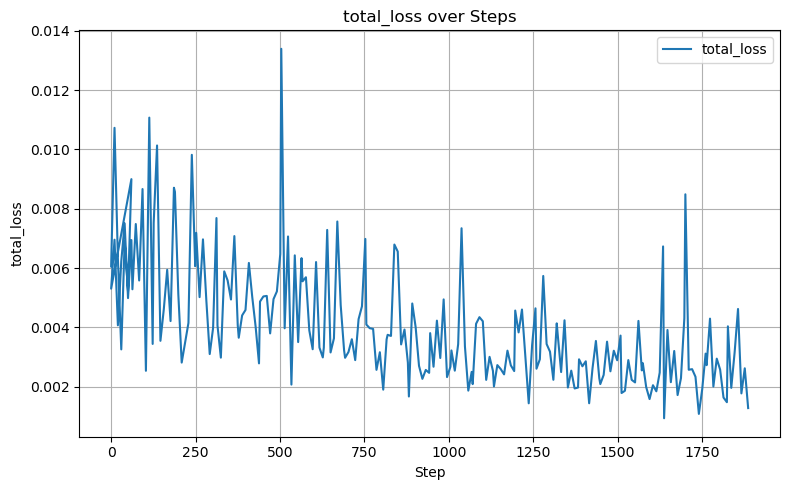

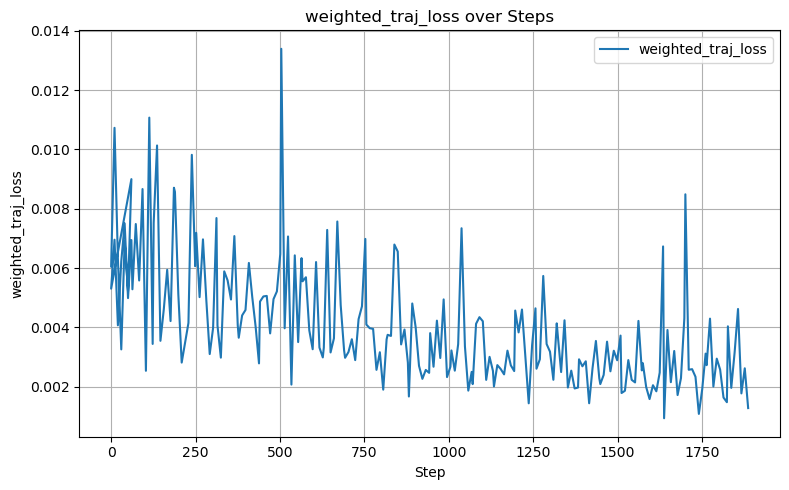

In [ ]:
# Launch Training
train(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler=scheduler,
    logger=logger,
    num_epochs=30,
)


# 🏆 Load your best model

In [ ]:
# load model
dir = 'models'
model = BetterDrivingPlanner(
                 num_modes=6,
                 future_steps=60,
                 dropout_val=0.021,
                 use_layernorm=True,
                 freeze_pretrained=True
                )
model.load_state_dict(torch.load(os.path.join(dir, "Real-1.547-4.36.pth")))

C:\Users\vglab\AppData\Local\Temp\ipykernel_32476\1063194181.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(dir, "Real-1.

<All keys matched successfully>

# 🔎 Inference Test

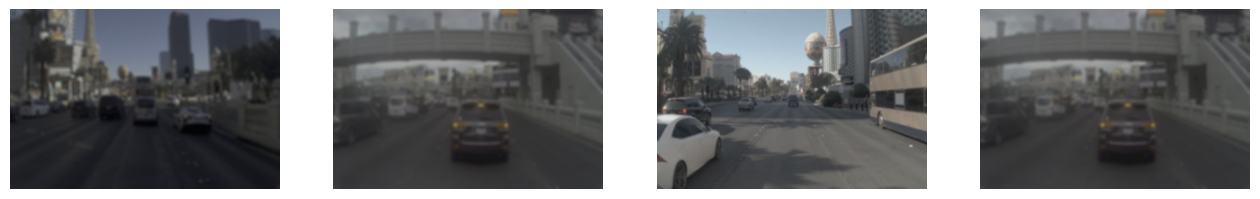

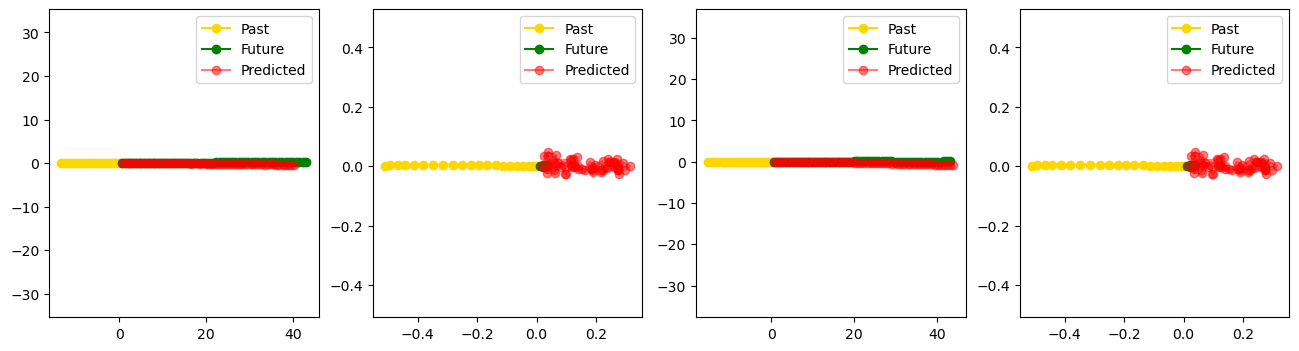

In [ ]:
val_batch_zero = next(iter(val_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
camera = val_batch_zero['camera'].to(device)
history = val_batch_zero['history'].to(device)
future = val_batch_zero['future'].to(device)

model.eval()
with torch.no_grad():
    traj_pred, conf_pred = model(camera, history)
    pred_future = model.predict_best(traj_pred, conf_pred)

camera = camera.cpu().numpy()
history = history.cpu().numpy()
future = future.cpu().numpy()

pred_future = pred_future.cpu().numpy()

k=4
selected_indices = random.choices(np.arange(len(camera)), k=k)

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].imshow(camera[idx].transpose(1, 2, 0))
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].plot(history[idx, :, 0], history[idx, :, 1], "o-", color="gold", label="Past")
    axis[i].plot(future[idx, :, 0], future[idx, :, 1], "o-", color="green", label="Future")
    axis[i].plot(pred_future[idx, :, 0], pred_future[idx, :, 1], "o-", color="red", label="Predicted", alpha=0.5)
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

# 🐐 Kaggle Submission

In [ ]:
import pandas as pd
test_data_dir = "test_public_real"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]

test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)
model.eval()
all_plans = []
device = 'cuda'
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        pred_future = model(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase3.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

RuntimeError: DataLoader worker (pid(s) 12920, 25196) exited unexpectedly